In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [0]:
os.chdir("drive/My Drive/Colab Notebooks/EVA/Assignment 18/")

In [4]:
!ls

 68LandmarksAlignedFrames      results
 alignedVidFrames	       shape_predictor_5_face_landmarks.dat
 bestvid.mp4		       shape_predictor_68_face_landmarks.dat
 faceBlendCommon.py	       stabilizedFrames
'Face Motion Detector.ipynb'   stitched
 family.jpg		       Take1.mov
 myFace2.mov		       video.avi
 __pycache__		       vidFrames
 renderFace.py


In [0]:
import dlib
import cv2
import numpy as np
from renderFace import renderFace
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
matplotlib .rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/EVA/Assignment 18/"

In [0]:
import faceBlendCommon as fbc
from renderFace import renderFace2

In [0]:
PREDICTOR_PATH_5 = PATH + "shape_predictor_5_face_landmarks.dat"
PREDICTOR_PATH_68 = PATH + "shape_predictor_68_face_landmarks.dat"

In [0]:
!mkdir vidFrames 
!mkdir alignedVidFrames
!mkdir 68LandmarksAlignedFrames
!mkdir stabilizedFrames
!mkdir stitched

In [0]:
videoFileName = PATH + "Take3.mov"

# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
  print("Unable to load video")

In [0]:
FPS = cap.get(cv2.CAP_PROP_FPS)

In [55]:
success, image = cap.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
count = 0
while success:
  cv2.imwrite("vidFrames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success, image = cap.read()
  if image is not None:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  count += 1

print(f"number of frames: {count+1}")

number of frames: 176


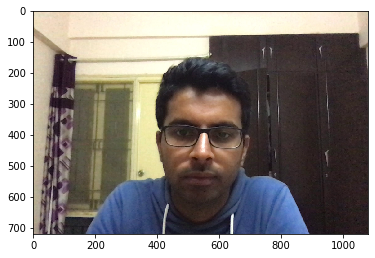

In [56]:
sample_image = cv2.imread("vidFrames/frame1.jpg") 
plt.imshow(sample_image)
plt.show()

In [0]:
# get the face detector
faceDetector = dlib.get_frontal_face_detector()

# get the 5 point landmark detector
landmarkDetector5 = dlib.shape_predictor(PREDICTOR_PATH_5)

# get the 5 point landmark detector
landmarkDetector68 = dlib.shape_predictor(PREDICTOR_PATH_68)

### Aligning the images 

In [0]:
for frame in os.listdir("vidFrames"):
    img = cv2.imread(f"vidFrames/{frame}")
    points = fbc.getLandmarks(faceDetector, landmarkDetector5, img)
    # points returend by getLandmarks is list type and we will convert it to numpy array
    points = np.array(points)
    
    # convert image to floating point in the range of 0 to 1
    img = np.float32(img)/255.0

    # output image shape, taking same as the original image
    h, w = img.shape[0], img.shape[1]

    # Normalize image to output coordinates.
    imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), img, points)

    imNorm = np.uint8(imNorm*255)

    # save the image to alignedFrames folder
    filepath = f"alignedVidFrames/{frame}"
    cv2.imwrite(filepath, imNorm)

### 68 point landmarks on aligned faces

In [0]:
def writeLandmarksToFile(landmarks, landmarksFilename):
    with open(landmarksFilename, 'w') as f:
        for p in landmarks.parts():
            f.write(f'{int(p.x), int(p.y)}')
    f.close()

In [0]:
for frame in os.listdir("alignedVidFrames"):
    img = cv2.imread(f"alignedVidFrames/{frame}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # face detection
    faceRects = faceDetector(img, 0)

    # landmark detection
    # List to store landmarks of all detected faces
    landmarksAll = []

    # Loop over all detected face rectangles
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        # For every face rectangle, run landmarkDetector
        landmarks = landmarkDetector68(img, newRect)
        # Store landmarks for current face
        landmarksAll.append(landmarks)

        # Next, we render the outline of the face using
        # detected landmarks.
        renderFace(img, landmarks)

        # The code below saves the landmarks to 
        if not os.path.exists("68LandmarksAlignedFrames/landmarks68"):
            os.makedirs("68LandmarksAlignedFrames/landmarks68")
        landmarksFileName = os.path.join("68LandmarksAlignedFrames/landmarks68", frame + f"_face_{i}.txt")

        # Write landmarks to disk
        writeLandmarksToFile(landmarks, landmarksFileName)

    # saving the image with landmarks 
    outputFileName = f"68LandmarksAlignedFrames/{frame}"
    # print("Saving output image to", outputFileName)
    cv2.imwrite(outputFileName, img)

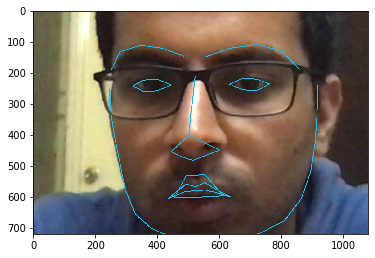

In [61]:
landmarked_image = cv2.imread("68LandmarksAlignedFrames/frame168.jpg")
plt.imshow(landmarked_image[:,:, ::-1])

### Stabilsing landmarks by optical flow

In [0]:
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [0]:
winName = "Stabilized facial landmark detector"

In [0]:
winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
imPrev = sample_image

In [0]:
# Finding the size of the image.
size = imPrev.shape[0:1]

In [0]:
# detector = dlib.get_frontal_face_detector()
# landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [0]:
# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

In [0]:
eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

In [0]:
# drawPolyline2 is for landmarks as list of tuples instead of orginal landmarks object 
def drawPolyline2(im, landmarks, start, end, isClosed=False):
    points = []
    for i in range(start, end+1):
        point = [landmarks[i][0], landmarks[i][1]]
        points.append(point)

    points = np.array(points, dtype=np.int32)
    cv2.polylines(im, [points], isClosed, (255, 200, 0),
                  thickness=2, lineType=cv2.LINE_8)

# Use this function for 68-points facial landmark detector model
def renderFace3(im, landmarks):
    assert(len(landmarks) == 68)
    drawPolyline2(im, landmarks, 0, 16)           # Jaw line
    drawPolyline2(im, landmarks, 17, 21)          # Left eyebrow
    drawPolyline2(im, landmarks, 22, 26)          # Right eyebrow
    drawPolyline2(im, landmarks, 27, 30)          # Nose bridge
    drawPolyline2(im, landmarks, 30, 35, True)    # Lower nose
    drawPolyline2(im, landmarks, 36, 41, True)    # Left eye
    drawPolyline2(im, landmarks, 42, 47, True)    # Right Eye
    drawPolyline2(im, landmarks, 48, 59, True)    # Outer lip
    drawPolyline2(im, landmarks, 60, 67, True)    # Inner lip

In [71]:
for frame in os.listdir("alignedVidFrames"):
    if frame.endswith(".jpg"):
        im = cv2.imread(f"alignedVidFrames/{frame}")
        # if (count==0):
        #     t = cv2.getTickCount()

        # Grab a frame
        imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        # COnverting to grayscale
        imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        height = im.shape[0]
        IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
        # Resize image for faster face detection
        imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
        imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
        # Skipping the frames for faster processing
        # if (count % SKIP_FRAMES == 0):
        faces = faceDetector(imSmallDlib,0)

        # If no face was detected
        if len(faces)==0:
            print("No face detected")

        # If faces are detected, iterate through each image and detect landmark points
        else:
            for i in range(0,len(faces)):
                # Face detector was found over a smaller image.
                # So, we scale face rectangle to correct size.
                newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
                    int(faces[i].top() * IMAGE_RESIZE),
                    int(faces[i].right() * IMAGE_RESIZE),
                    int(faces[i].bottom() * IMAGE_RESIZE))
                
                # Detect landmarks in current frame
                landmarks = landmarkDetector68(imDlib, newRect).parts()
                
                # Handling the first frame of video differently,for the first frame copy the current frame points
                
                if (isFirstFrame==True):
                    imGrayPrev = imGray
                    pointsPrev=[]
                    pointsDetectedPrev = []
                    [pointsPrev.append((p.x, p.y)) for p in landmarks]
                    [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

                # If not the first frame, copy points from previous frame.
                else:
                    pointsPrev=[]
                    pointsDetectedPrev = []
                    pointsPrev = points
                    pointsDetectedPrev = pointsDetectedCur

                # pointsDetectedCur stores results returned by the facial landmark detector
                # points stores the stabilized landmark points
                points = []
                pointsDetectedCur = []
                [points.append((p.x, p.y)) for p in landmarks]
                [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

                # Convert to numpy float array
                pointsArr = np.array(points,np.float32)
                pointsPrevArr = np.array(pointsPrev,np.float32)

                # If eye distance is not calculated before
                if eyeDistanceNotCalculated:
                    eyeDistance = interEyeDistance(landmarks)
                    print(eyeDistance)
                    eyeDistanceNotCalculated = False

                if eyeDistance > 100:
                    dotRadius = 3
                else:
                    dotRadius = 2

                sigma = eyeDistance * eyeDistance / 400
                s = 2*int(eyeDistance/4)+1

                #  Set up optical flow params
                lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
                # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
                # ret, imGrayPyr= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)

                pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
                

                # Converting to float
                pointsArrFloat = np.array(pointsArr,np.float32)

                # Converting back to list
                points = pointsArrFloat.tolist()

                # Final landmark points are a weighted average of
                # detected landmarks and tracked landmarks
                for k in range(0,len(landmarks)):
                    d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
                    alpha = math.exp(-d*d/sigma)
                    points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])
            
                # Next, we render the outline of the face using
                # detected landmarks.
                renderFace3(imDlib, points)

            isFirstFrame = False
            # saving the image with landmarks 
            outputFileName = f"stabilizedFrames/{frame}"
            # print("Saving output image to", outputFileName)
            cv2.imwrite(outputFileName, imDlib)
            # Getting ready for next frame
            imPrev = im
            imGrayPrev = imGray
            continue

443


In [0]:
# joining the three types of images
for frame in os.listdir("vidFrames"):
    original = cv2.imread(f"vidFrames/{frame}")
    aligned = cv2.imread(f'68LandmarksAlignedFrames/{frame}')
    aligned = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
    stabilized = cv2.imread(f'stabilizedFrames/{frame}')
    stabilized = cv2.cvtColor(stabilized, cv2.COLOR_BGR2RGB)
    new_img = np.concatenate((original, aligned, stabilized), axis=1)
    cv2.imwrite(f"stitched/{frame}", new_img)

In [0]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=join(pathIn, files[i])
        #reading each files
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [0]:
pathIn = "stitched"
pathOut = 'video.avi'
fps = FPS
convert_frames_to_video(pathIn, pathOut, fps)